# Generative Adversarial Networks (GAN)


A Generative Adversarial Network (GAN) is a pair of neural networks — a generator that creates fake data and a discriminator that tries to tell real from fake — trained together in an adversarial game so the generator learns to produce realistic samples (images, audio, etc.).

### We'll be building a GAN Model (More specifically a DCGAN model) that is trained on several datasets, to generate realistic images.


### ------------------------------------------------------------------------------------------

## 1. MNIST Digits Dataset

In [ ]:
# Dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn # Neural Network basemodel
import torch.optim as optim  # Optimization algos
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils # Saving image grids

import os
import random


# Seeding
random.seed(67)
torch.manual_seed(67)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

import matplotlib.animation as animation
#from IPython.display import HTML


In [72]:
# Defining variables
mydevice = "cuda" if torch.cuda.is_available() else "cpu"

dataroot = "content/data" # Root directory for dataset
batch_size = 128

image_channel = 1 # 1 - Black/White , 3 - Coloured (RGB Format)

IMG_SIZE = 64

nz = 100 # Size of latent input vector
ngf = 64
ndf = 64

epochs = 5
lr = 0.0002

beta1 = 0.5
ngpu = 1


# Dataset fraction - What fraction of dataset to consider
dataset_fraction = 1




cuda


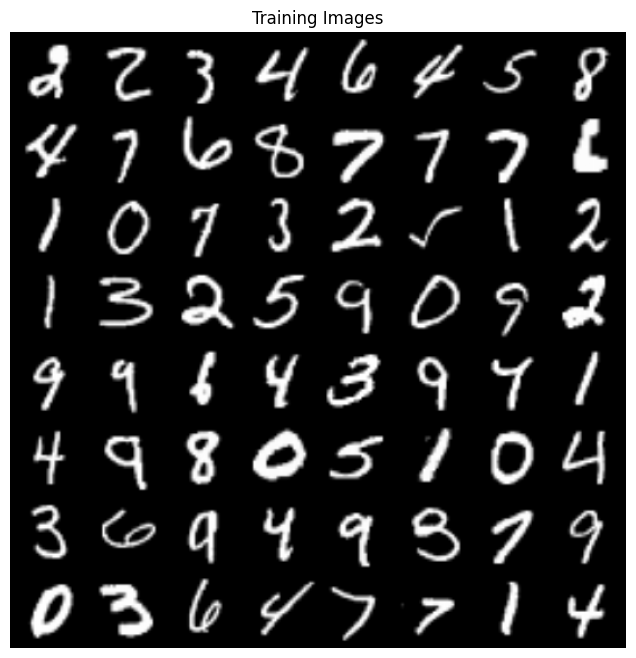

In [73]:
device = torch.device(mydevice)
print(device)

# Preparing Datasets
compose = transforms.Compose([
                             transforms.Resize(IMG_SIZE),
                             transforms.CenterCrop(IMG_SIZE),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,))
                            ])

dataset = datasets.MNIST(root=dataroot,
                         download = True,
                         transform = compose)

# dataset = datasets.ImageFolder(root=f"{dataroot}/celeba",
#                            transform=transforms.Compose([
#                                transforms.Resize(IMG_SIZE),
#                                transforms.CenterCrop(IMG_SIZE),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

# Taking only a subset
num_images = len(dataset)
# Calculate the size of our subset
subset_size = int(num_images * dataset_fraction)
# Get a list of random indices
indices = list(range(num_images))
random.shuffle(indices)
# Select the first 'subset_size' indices
subset_indices = indices[:subset_size]
# Create the subset
dataset_subset = torch.utils.data.Subset(dataset, subset_indices)

# Creating the dataloader
dataloader = torch.utils.data.DataLoader(dataset_subset , batch_size = batch_size , shuffle = True , num_workers = 2)

# Showing some training images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [74]:
# Weight Initialization

def weights_init(m):
  # m - Some Layer(Conv or Batchnorm layer)
  classname = m.__class__.__name__

  # Check if conv layer
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)

  # Check if batchnorm layer
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

### Generator
The generator,
G
G
, is designed to map the latent space vector (
z
z
) to data-space. Since our data are images, converting
z
z
 to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of
[
−
1
,
1
]
[−1,1]
. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.



image.png


In [75]:
# Architecture: z (100) -> 1024 -> 512 -> 256 -> 128 -> 1 (Image Channel)

# Generator Model

class Generator(nn.Module):

  def __init__(self , ngpu):
        super(Generator , self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(

              # Input Layer (z --> Conv1)  (z --> 1024x4x4)
              nn.ConvTranspose2d(in_channels = nz ,  # Input Channels (z = 100)
                                out_channels=ngf*16, # Output Feature Maps = 64*16 = 1024
                                kernel_size = 4 ,
                                stride = 1 ,
                                padding = 0 ,
                                bias = False),
              # Output = (Input - 1) * Stride + KernelSize - 2 * Padding
              nn.BatchNorm2d(ngf*16),
              nn.ReLU(True),

              # Conv1 Layer
              nn.ConvTranspose2d(
                  in_channels = ngf*16, # 1024
                  out_channels = ngf*8,#512
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False
              ),
              nn.BatchNorm2d(ngf*8),
              nn.ReLU(True),


              # Conv2 Layer
              nn.ConvTranspose2d(
                  in_channels = ngf*8, # 512
                  out_channels = ngf*4,# 256
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False
              ),
              nn.BatchNorm2d(ngf*4),
              nn.ReLU(True),


              # Conv3 Layer
              nn.ConvTranspose2d(
                  in_channels = ngf*4, # 256
                  out_channels = ngf*2,# 128
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False
              ),
              nn.BatchNorm2d(ngf*2),
              nn.ReLU(True),


              #Conv4 Layer
              nn.ConvTranspose2d(
                  in_channels = ngf*2, #128
                  out_channels = image_channel,
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False
              ),
              nn.Tanh()  # Compresses the input between [-1,1]
    )


  def forward(self , input):
    return self.main(input)


### Discriminator
As mentioned, the discriminator,
D
D
, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here,
D
D
 takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both
G
G
 and
D
D
.

In [76]:
# Discriminator Model

class Discriminator(nn.Module):
    def __init__(self , ngpu):
      super(Discriminator , self).__init__()
      self.ngpu = ngpu

      self.main = nn.Sequential(
          # input is ``(nc) x 64 x 64``
          nn.Conv2d(image_channel, ndf, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU is used instead of standard ReLU. Suggested by the paper

          # state size. ``(ndf) x 32 x 32``
          nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 2),
          nn.LeakyReLU(0.2, inplace=True),

          # state size. ``(ndf*2) x 16 x 16``
          nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 4),
          nn.LeakyReLU(0.2, inplace=True),

          # state size. ``(ndf*4) x 8 x 8``
          nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 8),
          nn.LeakyReLU(0.2, inplace=True),

          # state size. ``(ndf*8) x 4 x 4``
          nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
          nn.Sigmoid()

      )

    def forward(self , input):
      return self.main(input)

In [77]:
# Creating the generator
G = Generator(ngpu)
G.to(device)
# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
# Initiating the weights
G.apply(weights_init)

print("Generator Model Architecture: ")
print(G)
print("\n\n")


# Creating the Discriminiator
D = Discriminator(ngpu)
D.to(device)
# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
# Initialize weights
D.apply(weights_init)

print("Discriminator Model Architecture: ")
print(D)

Generator Model Architecture: 
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Loss Functions and Optimizers


In [78]:
# We'll be using the Binary Cross Entropy Loss (BCELoss)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

#### Part-1 Training the Discriminator:
Main Objective: Maximize the probability of correctly classifying real or fake
Practically, we wish to maximize the function --

log(D(x)) + log(1-D(G(z)))

First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss log(D(x)), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss
log(1-D(G(z))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator's optimizer.


In [79]:
# Training Loop Process

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.7684	Loss_G: 4.5535	D(x): 0.5497	D(G(z)): 0.5862 / 0.0171
[0/5][50/469]	Loss_D: 0.1249	Loss_G: 8.2536	D(x): 0.9839	D(G(z)): 0.0979 / 0.0004
[0/5][100/469]	Loss_D: 0.4725	Loss_G: 4.7636	D(x): 0.6984	D(G(z)): 0.0080 / 0.0195
[0/5][150/469]	Loss_D: 2.1361	Loss_G: 11.8242	D(x): 0.9880	D(G(z)): 0.8407 / 0.0000
[0/5][200/469]	Loss_D: 0.1864	Loss_G: 3.9262	D(x): 0.9110	D(G(z)): 0.0713 / 0.0323
[0/5][250/469]	Loss_D: 0.1780	Loss_G: 3.7246	D(x): 0.8877	D(G(z)): 0.0488 / 0.0366
[0/5][300/469]	Loss_D: 2.4111	Loss_G: 9.0469	D(x): 0.9973	D(G(z)): 0.8681 / 0.0004
[0/5][350/469]	Loss_D: 0.3968	Loss_G: 2.8024	D(x): 0.8710	D(G(z)): 0.1945 / 0.0923
[0/5][400/469]	Loss_D: 2.6964	Loss_G: 0.0906	D(x): 0.1431	D(G(z)): 0.0182 / 0.9192
[0/5][450/469]	Loss_D: 0.5689	Loss_G: 1.2551	D(x): 0.6450	D(G(z)): 0.0682 / 0.3360
[1/5][0/469]	Loss_D: 0.3369	Loss_G: 2.8995	D(x): 0.8459	D(G(z)): 0.1312 / 0.0756
[1/5][50/469]	Loss_D: 0.5702	Loss_G: 2.1337	D(x): 0.8381	D(G(z)):

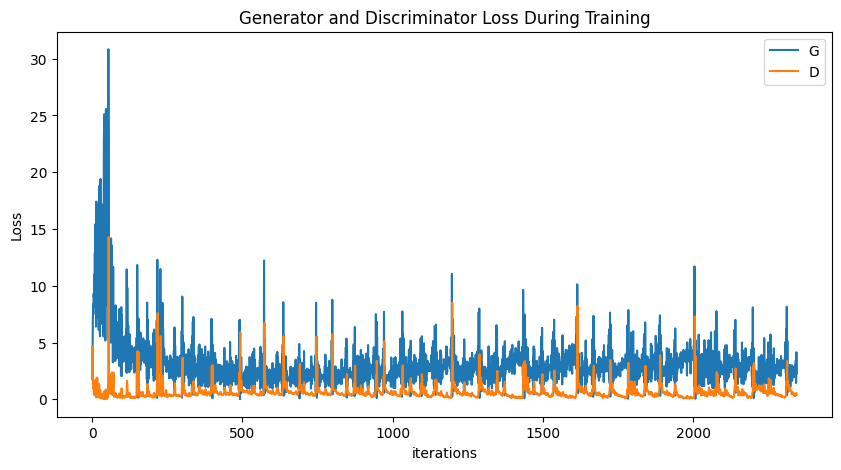

In [80]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [81]:
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

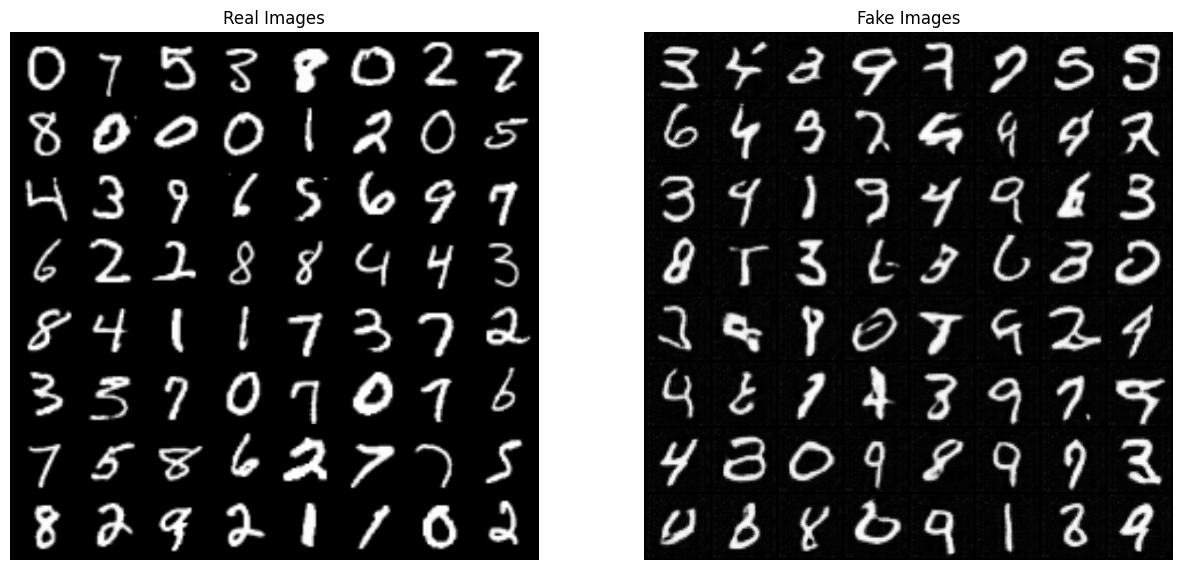

In [82]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()